In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes", "")
    out_dir = base_dir + "/9_Figures/1_IL2RAKO"

In [49]:
sig_file = base_dir + '/9_Figures/1_IL2RAKO/0_all/louvain_signature_genes_neworder.csv'
sig_df = pd.read_csv(sig_file)
sig_genes = set([i for sublist in sig_df.values.tolist() for i in sublist])

In [164]:
###----- Arm v.s. Cl13 log2fc compiling
avc_dir = base_dir + '/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/2_DE/perCluster_KO_vs_WT'
i = 1
i_avc_file = avc_dir + '/P%s/CD25WT/CD25WT_vs_CD25KO_differential.csv'%i
avc_df = pd.read_csv(i_avc_file, index_col=0)[[]]

# Highly expressed in at least one condition:
he_genes = []

for i in range(1, 8):
    i_avc_file = avc_dir + '/P%s/CD25WT/CD25WT_vs_CD25KO_differential.csv'%i
    i_avc_df = pd.read_csv(i_avc_file, index_col=0)
    # For padj >= 0.3, ignore log2fc
    i_avc_df_sig = [True if i_avc_df['t-test_overestim_var_padj'][x] <= 1 else False 
                    for x in range(0, len(i_avc_df))]
    i_avc_df['log2fc'] = [ i_avc_df['t-test_logfc'].tolist()[x] if i_avc_df_sig[x] == True 
                          else 0 for x in range(0, len(i_avc_df)) ]
    # If one condition has < 0.001 expr value, ignore log2fc
    i_avc_min_expr = i_avc_df[i_avc_df.columns.tolist()[:2]].min(axis=1)
    min_cutoff = i_avc_min_expr > 0.015
    i_avc_df['log2fc'] = [ i_avc_df['log2fc'].tolist()[x] if min_cutoff[x] == True 
                          else 0 for x in range(0, len(i_avc_df)) ]
    # Compile
    i_avc_df = i_avc_df[['log2fc']]
    i_avc_df.columns = ["P%s"%i]
    avc_df = avc_df.join(i_avc_df)

In [165]:
# Select genes that are at least abs(log2fc) > 0.25
max_list = avc_df.max(axis=1)
min_list = avc_df.min(axis=1)
use_bool = [True if max_list[i] > 2 or min_list[i] < -2 else False for i in range(0, len(max_list))]
avc_df_slt = avc_df[ use_bool ]
# Select signature genes
sig_genes_use = [x for x in avc_df_slt.index if x in sig_genes]
avc_df_slt = avc_df_slt.loc[sig_genes_use]
# Sqrt of log2fc
#avc_df_slt_sqrt = avc_df_slt.copy()
#for i in avc_df_slt.columns:
#    avc_df_slt_sqrt[i] = abs(avc_df_slt[i]) / avc_df_slt[i] * np.sqrt(abs(avc_df_slt[i]))
# Fill in 0 for NA   
#avc_df_slt_sqrt = avc_df_slt_sqrt.fillna(0)

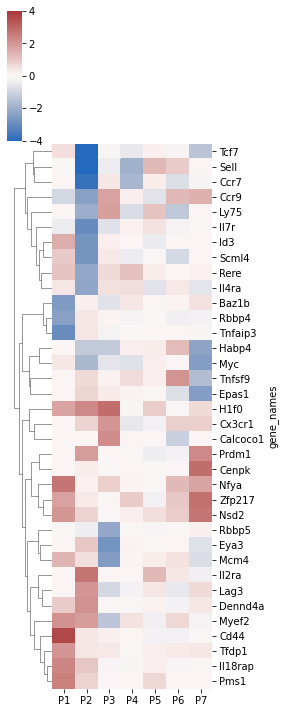

In [188]:
###----- Il2 promoted gene heatmap
out_figure = out_dir + "/WT_vs_KO_log2fc_heatmap.png"
out_csv = out_dir + "/WT_vs_KO_log2fc_heatmap.csv"

hm = sns.clustermap(avc_df_slt, cmap="vlag", vmin=-4, vmax=4, center=0,
               col_cluster=False,  figsize=(4,10))
hm.savefig(out_figure)
plt.show()
plt.close()

# Without labels
hm = sns.clustermap(avc_df_slt, cmap="vlag", vmin=-4, vmax=4, center=0,
                      yticklabels=False, xticklabels=False, cbar_pos=None,
                      col_cluster=False, figsize=(4,10))
hm_ax = hm.ax_heatmap
hm_ax.set_xlabel("")
hm_ax.set_ylabel("")
hm_ax.set_xticklabels([])
hm.savefig(out_figure.replace(".png", "_noleg.png"))
plt.close()

hm_dgram = hm.dendrogram_row.dendrogram
hm_order = [avc_df_slt.index.tolist()[int(x)] for x in hm_dgram['ivl']]
hm_order_df = avc_df_slt.loc[hm_order]
hm_order_df.to_csv(out_csv, index=False)